In [1]:
import pandas as pd
import numpy as np
import pickle
from urllib.request import urlopen
import matplotlib.pyplot as plt
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.optimization as opt
import biogeme.version as ver
from biogeme.expressions import Beta, Variable


We first print the version of Biogeme that has been used to generate the results.

In [2]:
print(ver.getText())

biogeme 3.2.8 [2021-09-01]
Version entirely written in Python
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



Running the experiments take some time. If you prefer to read the results from a file, set the following variable to `True`

In [3]:
read_results_from_file = True

In [4]:
url_root = (
    'https://courses.edx.org/asset-v1:EPFLx+ChoiceModels2x+3T2021+type@asset+block@'
)

In [5]:
def read_object_from_file(name):
    pickle_file = f'{url_root}{name}.pickle'
    with urlopen(pickle_file) as p:
        object = pickle.load(p)
    return object

# Sampling procedures

Load the population.

In [6]:
url = ('https://raw.githubusercontent.com/michelbierlaire/mooc-discrete-choice/master/'
       'syntheticPopulationWithChoice.zip')
population = pd.read_csv(url)

We set the seed so that the results are reproducible

In [7]:
np.random.seed(seed=9021967)

Procedure for simple random sampling

In [8]:
def simpleRandomSample(sampleSize=1000):
    return 'SRS', population.sample(n=sampleSize)

Generic stratified sampling procedure

In [9]:
def stratifiedSample(name, mask, H, sampleSize=1000):
    # name: name of the sampling scheme
    # mask: list of masks identifying the strata
    # H: target shares for each stratum
    groupname = f'{name}Group'
    # Calculate the share of each group in the population
    for i, m in enumerate(mask):
        population.loc[m, groupname] = i
    # Sampling
    groupsize = np.array(H) * sampleSize
    def sampleStratum(x):
        size = int(groupsize[int(x[groupname].mean())])
        if size == 0:
            return None
        elif size > x.shape[0]:
            # not enough individual in stratum to reach the requirements
            return x
        else:
            return x.sample(n=size)
    # The statement 'int(x[groupname].mean())' retrieves the index of the group.
    sample = (population.groupby(groupname).
              apply(sampleStratum).
              reset_index(drop=True))
    population.drop(groupname, axis='columns', inplace=True)
    return sample

## Exogenously stratified Sample

The strata are defined based on trip purpose and car availability. As the choice is not involved in the definition of strata, the stratified sampling is *exogenous*. Target shares in the sample: 25% for each stratum

In [10]:
def xss(sampleSize=1000):
    xssMask = [(population['TripPurpose'] == i) & (population['CarAvail'] == j) 
               for i in [1, 2] 
               for j in [1, 3]]
    H = [0.25]*4
    name = 'XSS'
    return name, stratifiedSample(name, xssMask, H, sampleSize)

## Endogenously stratified Sample 1

The strata are defined based on car availability and the chosen alternative.  As the choice is involved in the definition of strata, the stratified sampling is *endogenous*. Target shares in the sample: there are 5 non empty strata, taking 20% each

In [11]:
def ess1(sampleSize=1000):
    ess1Mask = [(population['CarAvail'] == i) & (population['Choice'] == j) 
                for i in [1, 3] for j in [0, 1, 2]]
    H = [0.2, 0.2, 0.2, 0.2, 0.0, 0.2]
    name = 'ESS1'
    return name, stratifiedSample(name, ess1Mask, H, sampleSize)

## Endogenously stratified Sample 2

The strata are defined based on the trip purpose, the language and the chosen alternative.   As the choice is involved in the definition of strata, the stratified sampling is *endogenous*. Target shares in the sample: there are 10 non empty strata, taking 10% each

In [12]:
def ess2(sampleSize=1000):
    ess2Mask = [(population['CarAvail'] == i) & (population['LangCode'] == j) & (population['Choice'] == k)
                for i in [1, 3] 
                for j in [1, 2] 
                for k in [0, 1, 2]]
    H = [0.1, 0.1, 0.1, 0.1, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.1]
    name = 'ESS2'
    return name, stratifiedSample(name, ess2Mask, H, sampleSize)

# Choice model

The specification of the choice model is available in the file <code>spec_optima</code>. Note that it is the exact same specification that has been used to generate the synthetic choices.

If the file is in your local directory, simply use the following statement to obtain the model specification. For this notebook running on a remote server, we have copied the code in the following cell. 

In [13]:
#from spec_optima import V, av, Choice

In [14]:
# File spec_optima.py
#
# Definition of the variables in the data file
Id = Variable('Id')
MarginalCostPT = Variable('MarginalCostPT')
WaitingTimePT = Variable('WaitingTimePT')
CostCarCHF = Variable('CostCarCHF')
NbTransf = Variable('NbTransf')
distance_km = Variable('distance_km')
TimePT = Variable('TimePT')
TimeCar = Variable('TimeCar')
OccupStat = Variable('OccupStat')
LangCode = Variable('LangCode')
CarAvail = Variable('CarAvail')
Education = Variable('Education')
TripPurpose = Variable('TripPurpose')
Prob0 = Variable('Prob0')
Prob1 = Variable('Prob1')
Prob2 = Variable('Prob2')
Choice = Variable('Choice')

TimePT_scaled = TimePT / 200
TimeCar_scaled = TimeCar / 200
MarginalCostPT_scaled = MarginalCostPT / 10
CostCarCHF_scaled = CostCarCHF / 10
distance_km_scaled = distance_km / 5

ASC_PT_GERMAN_CARAVAIL = Beta('ASC_PT_GERMAN_CARAVAIL', 0, None, None, 0)

ASC_PT_GERMAN_NOCARAVAIL = Beta('ASC_PT_GERMAN_NOCARAVAIL', 0, None, None, 0)

ASC_PT_GERMAN = ASC_PT_GERMAN_CARAVAIL * (
    CarAvail == 1
) + ASC_PT_GERMAN_NOCARAVAIL * (CarAvail != 1)

ASC_PT_FRENCH_CARAVAIL = Beta('ASC_PT_FRENCH_CARAVAIL', 0, None, None, 0)

ASC_PT_FRENCH_NOCARAVAIL = Beta('ASC_PT_FRENCH_NOCARAVAIL', 0, None, None, 0)

ASC_PT_FRENCH = ASC_PT_FRENCH_CARAVAIL * (
    CarAvail == 1
) + ASC_PT_FRENCH_NOCARAVAIL * (CarAvail != 1)

ASC_PT = ASC_PT_GERMAN * (LangCode != 1) + ASC_PT_FRENCH * (LangCode == 1)

ASC_CAR_GERMAN = Beta('ASC_CAR_GERMAN', 0, None, None, 0)
ASC_CAR_FRENCH = Beta('ASC_CAR_FRENCH', 0, None, None, 0)

ASC_CAR = ASC_CAR_FRENCH * (LangCode == 1) + ASC_CAR_GERMAN * (LangCode != 1)

BETA_TIME_FULL = Beta('BETA_TIME_FULL', 0, None, None, 0)

BETA_TIME_PARTTIME = Beta('BETA_TIME_PARTTIME', 0, None, None, 0)

BETA_TIME_OTHERS = Beta('BETA_TIME_OTHERS', 0, None, None, 0)

BETA_TIME = (
    BETA_TIME_FULL * (OccupStat == 1)
    + BETA_TIME_PARTTIME * (OccupStat == 2)
    + BETA_TIME_OTHERS * (OccupStat == 3)
)

BETA_COST_PT = Beta('BETA_COST_PT', 0, None, None, 0)
BETA_COST_CAR = Beta('BETA_COST_CAR', 0, None, None, 0)

BETA_WAITING_WORK = Beta('BETA_WAITING_WORK', 0, None, None, 0)

BETA_WAITING_NONWORK = Beta('BETA_WAITING_NONWORK', 0, None, None, 0)

BETA_WAITING = BETA_WAITING_WORK * (
    TripPurpose == 1
) + BETA_WAITING_NONWORK * (TripPurpose != 1)

BETA_DIST_VOCA = Beta('BETA_DIST_VOCA', 0, None, None, 0)
BETA_DIST_HIGH_SCHOOL = Beta('BETA_DIST_HIGH_SCHOOL', 0, None, None, 0)

BETA_DIST_HIGHER = Beta('BETA_DIST_HIGHER', 0, None, None, 0)
BETA_DIST_UNIV = Beta('BETA_DIST_UNIV', 0, None, None, 0)

BETA_DIST = (
    BETA_DIST_VOCA * (Education == 3)
    + BETA_DIST_HIGH_SCHOOL * (Education == 4)
    + BETA_DIST_HIGHER * (Education == 6)
    + BETA_DIST_UNIV * (Education == 7)
)

LAMBDA_COST = 0.3214999879822265

V_PT = (
    ASC_PT
    + BETA_TIME * TimePT_scaled
    + BETA_COST_PT * models.boxcox(MarginalCostPT_scaled, LAMBDA_COST)
    + BETA_WAITING * WaitingTimePT ** 0.5
)

V_CAR = (
    ASC_CAR
    + BETA_TIME * TimeCar_scaled
    + BETA_COST_CAR * models.boxcox(CostCarCHF_scaled, LAMBDA_COST)
)

V_SM = BETA_DIST * distance_km_scaled


V = {0: V_PT, 1: V_CAR, 2: V_SM}

av = {0: 1, 1: CarAvail != 3, 2: 1}


The following function extract a sample from the population and estimate the choice model using this sample. 

In [15]:
def sampleAndEstimate(sampling):
    """
    :param sampling: function that performs the sampling
    :type sampling: function
    
    :return: estimated parameters
    :rtype: pandas.core.series.Series
    """
    name, sample = sampling()
    database = db.Database(name, sample)
    logprob = models.loglogit(V, av, Choice)
    biogeme = bio.BIOGEME(database, logprob)
    biogeme.modelName = name
    biogeme.generateHtml = False
    biogeme.generatePickle = False
    results = biogeme.quickEstimate(algoParameters={'maxiter': 100})
    pandasResults = results.getEstimatedParameters()
    return pandasResults['Value'].T

# Code the experiment

We first load the true values of the parameters

In [16]:
trueValuesOfTheParameters = {'ASC_CAR_FRENCH': -2.3964170553344726,
 'ASC_CAR_GERMAN': -3.5077163185270175,
 'ASC_PT_FRENCH_CARAVAIL': -2.361224966506705,
 'ASC_PT_FRENCH_NOCARAVAIL': 4.620997760623915,
 'ASC_PT_GERMAN_CARAVAIL': -2.3439305816983027,
 'ASC_PT_GERMAN_NOCARAVAIL': 2.4527259821306058,
 'BETA_COST_CAR': -1.6857507208148164,
 'BETA_COST_PT': -0.6736462504002271,
 'BETA_DIST_HIGHER': -1.6393574970002036,
 'BETA_DIST_HIGH_SCHOOL': -1.6452607972992284,
 'BETA_DIST_UNIV': -0.9390891835029462,
 'BETA_DIST_VOCA': -2.065461231848294,
 'BETA_TIME_FULL': -2.8832500848406823,
 'BETA_TIME_OTHERS': -0.16765495123858037,
 'BETA_TIME_PARTTIME': -2.0805822527972277,
 'BETA_WAITING_NONWORK': -0.2650336860286495,
 'BETA_WAITING_WORK': -0.1281619517257249}

The following procedure implements the experiment. It repeats sampling and estimation, stores all estimation results. When it is done, the mean and the standard deviation is calculated for each parameter, as well as the *t*-statistic. 

In [17]:
def runExperiment(sampling, repetitions):
    results = pd.DataFrame(columns=trueValuesOfTheParameters)
    for i in range(repetitions):
        if i % 20 == 0:
            print(f'Repetition {i}/{repetitions}')
        row = sampleAndEstimate(sampling)
        results = results.append(row)

    comparisons = pd.DataFrame.from_dict(trueValuesOfTheParameters, orient='index', columns=['True'])
    comparisons['Estimated'] = results.mean()
    comparisons['StdDev'] = results.std()
    comparisons['t-test'] = (comparisons['Estimated'] - comparisons['True']) / comparisons['StdDev']
    return results, comparisons

We also plot the distribution of the estimates, and compare it with the true value and the mean. 

In [18]:
def report(results, comparisons):
    for param in trueValuesOfTheParameters:
        xrangespan = 5
        plt.figure()
        plt.title(param)
        results[param].plot.hist(bins=20, 
                                 range=[comparisons.loc[param, 'Estimated'] 
                                        - xrangespan * comparisons.loc[param, 'StdDev'], 
                                       comparisons.loc[param, 'Estimated'] 
                                        + xrangespan * comparisons.loc[param, 'StdDev']])
        plt.axvline(trueValuesOfTheParameters[param], color='r', linestyle='dashed')
        plt.axvline(comparisons.loc[param, 'Estimated'], color='g', linestyle='dotted')

# Run the experiment

In [19]:
repetitions = 200

## Simple random sampling

In [20]:
%%time
if read_results_from_file:
    resultsSRS = read_object_from_file('resultsSRS')
    comparisonsSRS = read_object_from_file('comparisonsSRS')
else:
    resultsSRS, comparisonsSRS = runExperiment(simpleRandomSample, repetitions=repetitions)
    with open('resultsSRS.pickle', 'wb') as f:
        pickle.dump(resultsSRS, f)
    with open('comparisonsSRS.pickle', 'wb') as f:
        pickle.dump(comparisonsSRS, f)

CPU times: user 24.4 ms, sys: 3.19 ms, total: 27.6 ms
Wall time: 536 ms


The results below show the good adequation between the mean of the estimated parameters and the true value. In particular, the hypothesis that the true value of the parameter is what it is cannot be rejected for any parameter. 

Note that the share of individuals in the population with no car available is about 5%. The parameters associated with this group are estimated will less precision than the others.

In [21]:
comparisonsSRS

,True,Estimated,StdDev,t-test
ASC_CAR_FRENCH,-2.396417,-2.453572,0.552954,-0.103363
ASC_CAR_GERMAN,-3.507716,-3.639032,0.427953,-0.306847
ASC_PT_FRENCH_CARAVAIL,-2.361225,-2.393356,0.508356,-0.063206
ASC_PT_FRENCH_NOCARAVAIL,4.620998,4.643077,2.881529,0.007662
ASC_PT_GERMAN_CARAVAIL,-2.343931,-2.444248,0.317476,-0.315984
ASC_PT_GERMAN_NOCARAVAIL,2.452726,5.666676,2.997153,1.072334
BETA_COST_CAR,-1.685751,-1.717209,0.176565,-0.178170
BETA_COST_PT,-0.673646,-0.694112,0.083716,-0.244462
BETA_DIST_HIGHER,-1.639357,-1.782705,0.345509,-0.414888
BETA_DIST_HIGH_SCHOOL,-1.645261,-1.778359,0.360179,-0.369534


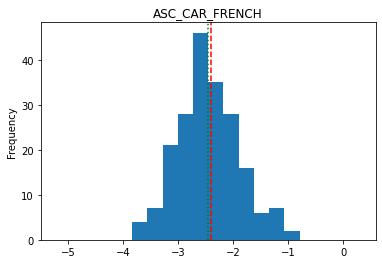

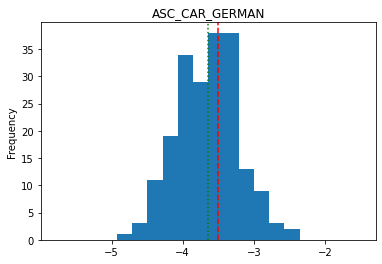

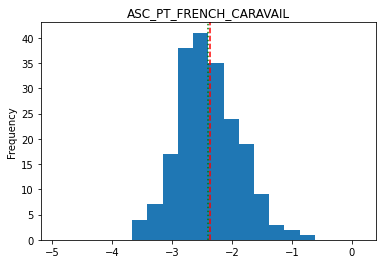

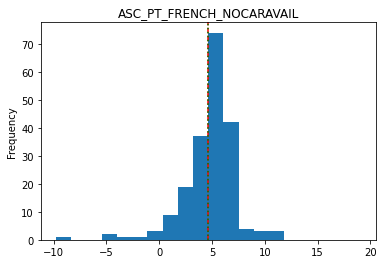

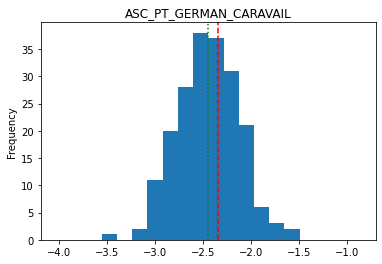

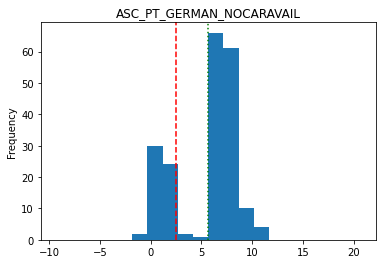

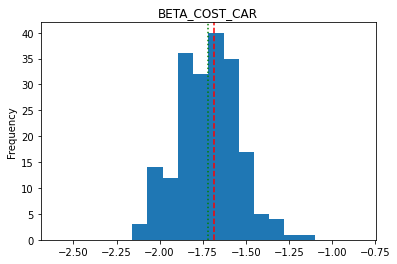

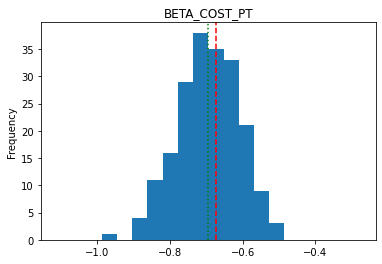

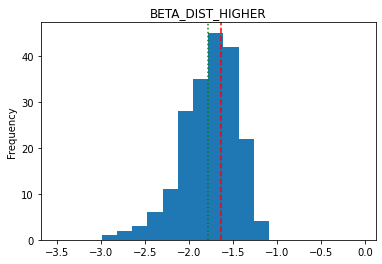

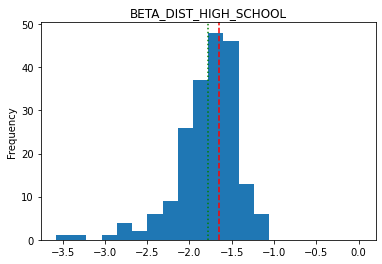

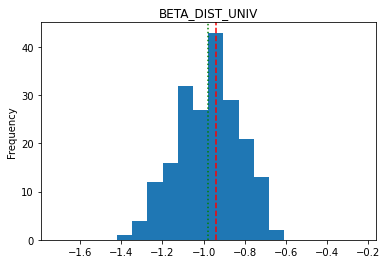

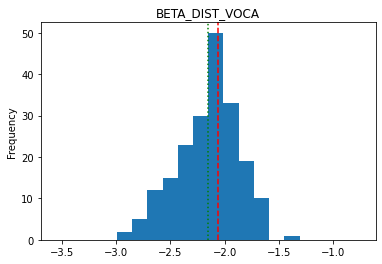

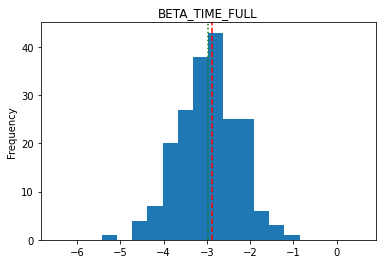

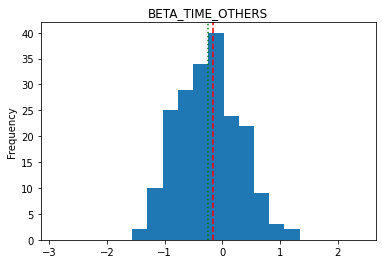

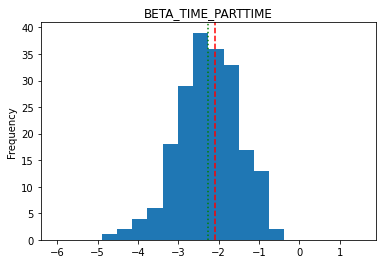

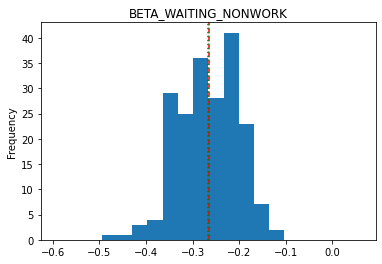

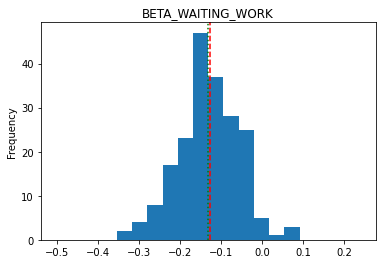

In [22]:
report(resultsSRS, comparisonsSRS)

## Exogenous sampling

In [23]:
%%time
if read_results_from_file:
    resultsXSS = read_object_from_file('resultsXSS')
    comparisonsXSS = read_object_from_file('comparisonsXSS')
else:
    resultsXSS, comparisonsXSS = runExperiment(xss, repetitions=repetitions)
    with open('resultsXSS.pickle', 'wb') as f:
        pickle.dump(resultsXSS, f)
    with open('comparisonsXSS.pickle', 'wb') as f:
        pickle.dump(comparisonsXSS, f)

CPU times: user 26.6 ms, sys: 3.98 ms, total: 30.6 ms
Wall time: 415 ms


The results below show again the good adequation between the mean of the estimated parameters and the true value. In particular, the hypothesis that the true value of the parameter is what it is cannot be rejected for any parameter. 

In [24]:
comparisonsXSS

,True,Estimated,StdDev,t-test
ASC_CAR_FRENCH,-2.396417,-2.597778,0.877041,-0.229591
ASC_CAR_GERMAN,-3.507716,-3.803797,0.613429,-0.482664
ASC_PT_FRENCH_CARAVAIL,-2.361225,-2.505974,0.787665,-0.183771
ASC_PT_FRENCH_NOCARAVAIL,4.620998,7.318822,2.278792,1.183883
ASC_PT_GERMAN_CARAVAIL,-2.343931,-2.513381,0.444103,-0.381556
ASC_PT_GERMAN_NOCARAVAIL,2.452726,2.718921,1.584743,0.167974
BETA_COST_CAR,-1.685751,-1.775543,0.262320,-0.342299
BETA_COST_PT,-0.673646,-0.705808,0.102517,-0.313726
BETA_DIST_HIGHER,-1.639357,-1.868511,0.510930,-0.448502
BETA_DIST_HIGH_SCHOOL,-1.645261,-2.100020,3.529456,-0.128847


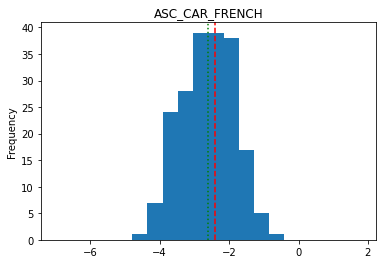

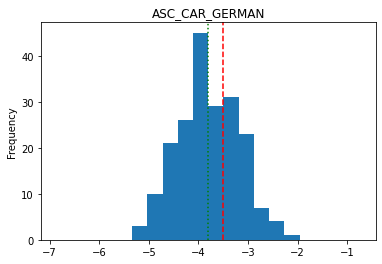

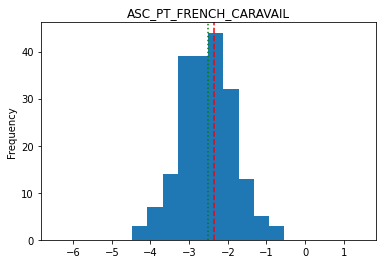

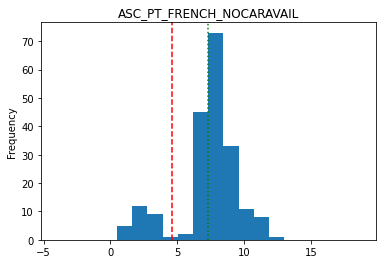

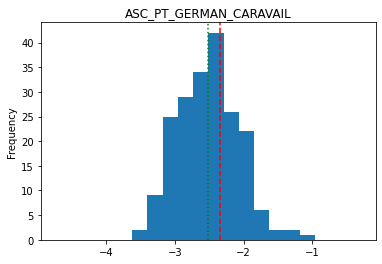

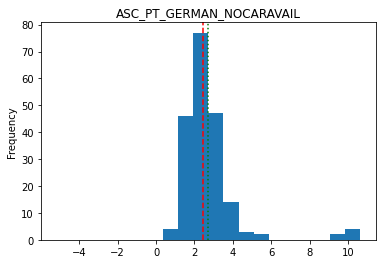

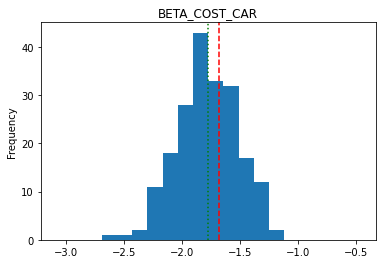

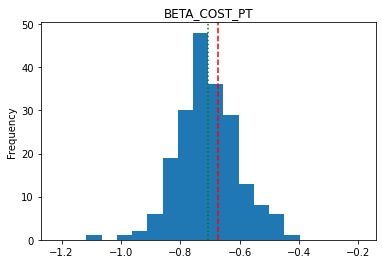

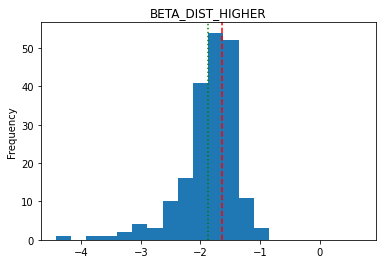

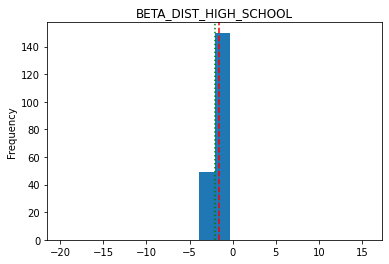

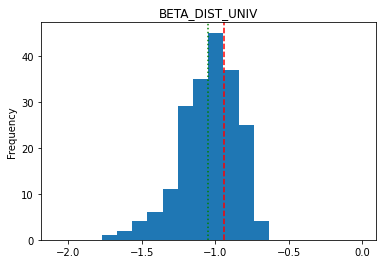

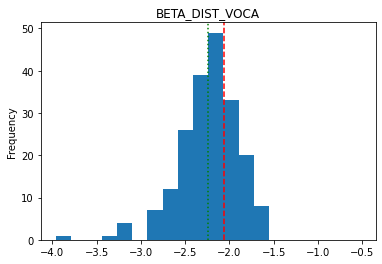

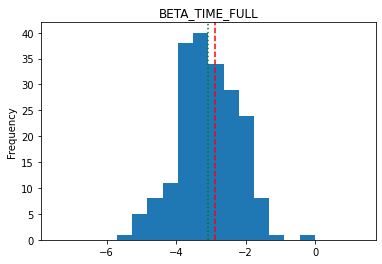

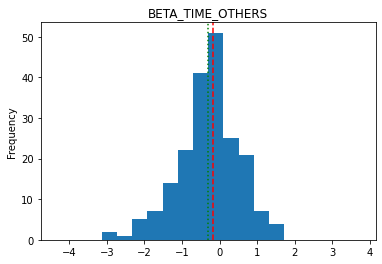

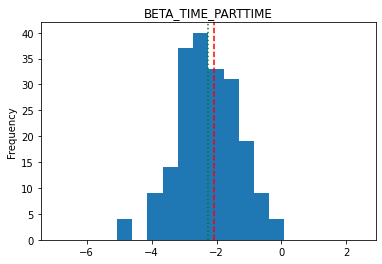

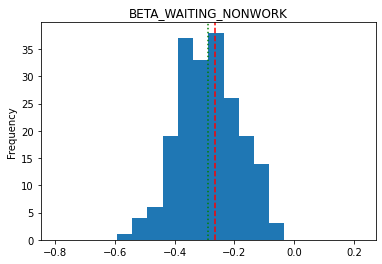

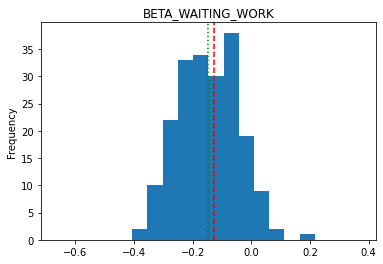

In [25]:
report(resultsXSS, comparisonsXSS)

## Endogenous sampling 1

In [26]:
%%time
if read_results_from_file:
    resultsESS1 = read_object_from_file('resultsESS1')
    comparisonsESS1 = read_object_from_file('comparisonsESS1')
else:
    resultsESS1, comparisonsESS1 = runExperiment(ess1, repetitions=repetitions)
    with open('resultsESS1.pickle', 'wb') as f:
        pickle.dump(resultsESS1, f)
    with open('comparisonsESS1.pickle', 'wb') as f:
        pickle.dump(comparisonsESS1, f)

CPU times: user 25 ms, sys: 3.2 ms, total: 28.2 ms
Wall time: 794 ms


The results below show  the good adequation between the mean of the estimated parameters and the true value for all parameters, **except the constants**. Note that the standard deviation for the constants related to the group of invidivuals with no car available has improved compared to the estimation with the XSS sample. 

In [27]:
comparisonsESS1

,True,Estimated,StdDev,t-test
ASC_CAR_FRENCH,-2.396417,-4.975528,0.472996,-5.452706
ASC_CAR_GERMAN,-3.507716,-6.092560,0.416623,-6.204275
ASC_PT_FRENCH_CARAVAIL,-2.361225,-3.830247,0.419872,-3.498740
ASC_PT_FRENCH_NOCARAVAIL,4.620998,-0.826331,0.851452,-6.397690
ASC_PT_GERMAN_CARAVAIL,-2.343931,-3.808882,0.252371,-5.804754
ASC_PT_GERMAN_NOCARAVAIL,2.452726,-2.635350,0.243884,-20.862720
BETA_COST_CAR,-1.685751,-1.758013,0.206733,-0.349542
BETA_COST_PT,-0.673646,-0.680573,0.092989,-0.074489
BETA_DIST_HIGHER,-1.639357,-1.749390,0.194682,-0.565193
BETA_DIST_HIGH_SCHOOL,-1.645261,-1.759774,0.176639,-0.648289


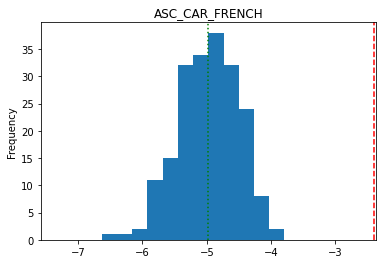

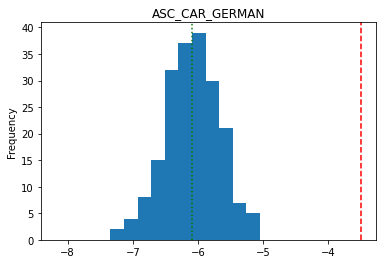

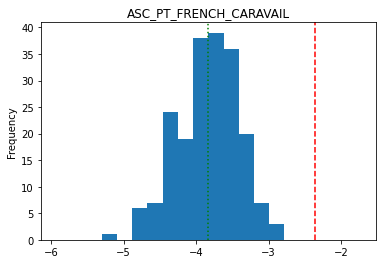

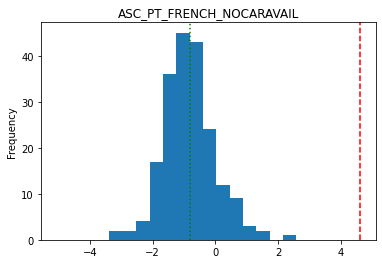

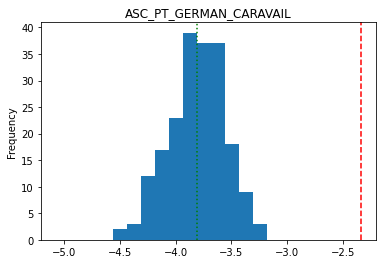

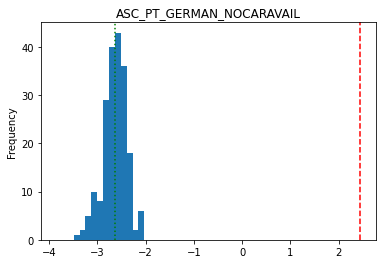

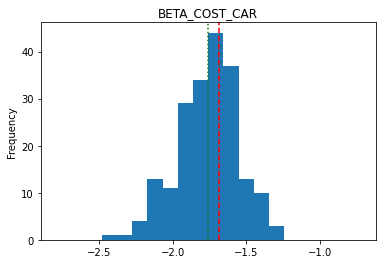

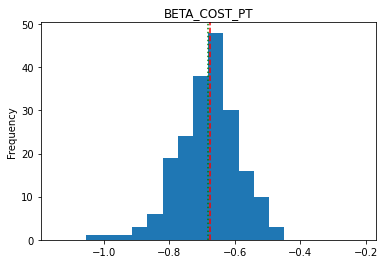

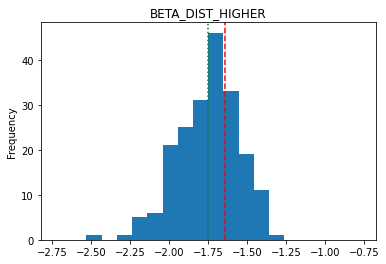

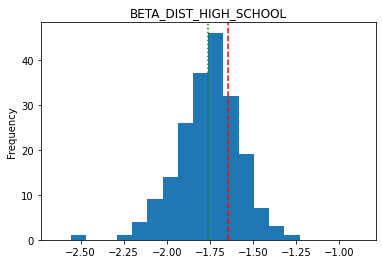

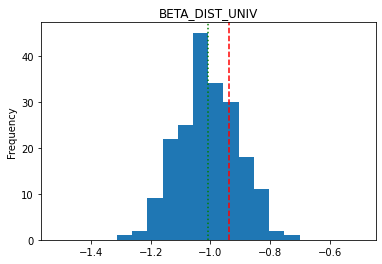

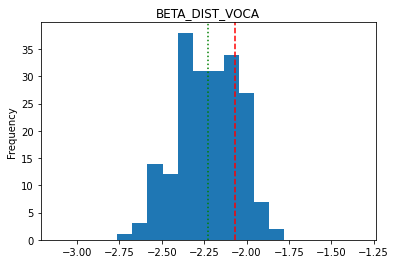

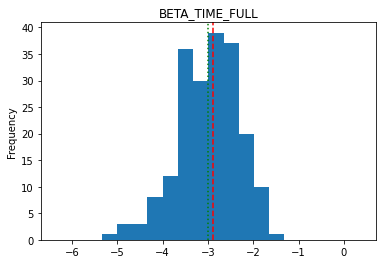

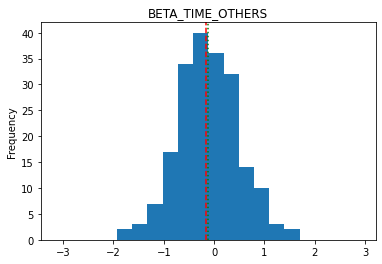

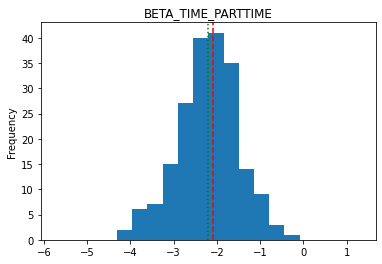

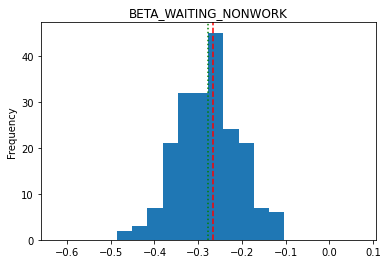

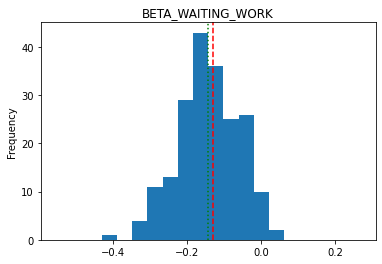

In [28]:
report(resultsESS1, comparisonsESS1)

## Endogenous sampling 2

In [29]:
%%time
if read_results_from_file:
    resultsESS2 = read_object_from_file('resultsESS2')
    comparisonsESS2 = read_object_from_file('comparisonsESS2')
else:
    resultsESS2, comparisonsESS2 = runExperiment(ess2, repetitions=repetitions)
    with open('resultsESS2.pickle', 'wb') as f:
        pickle.dump(resultsESS2, f)
    with open('comparisonsESS2.pickle', 'wb') as f:
        pickle.dump(comparisonsESS2, f)

CPU times: user 21.3 ms, sys: 2.67 ms, total: 23.9 ms
Wall time: 435 ms


Again, the results below show the good adequation between the mean of the estimated parameters and the true value for all parameters, **except the constants**.  

In [30]:
comparisonsESS2

,True,Estimated,StdDev,t-test
ASC_CAR_FRENCH,-2.396417,-5.685679,0.516144,-6.372761
ASC_CAR_GERMAN,-3.507716,-17.108553,0.566766,-23.997287
ASC_PT_FRENCH_CARAVAIL,-2.361225,-3.863515,0.357093,-4.206997
ASC_PT_FRENCH_NOCARAVAIL,4.620998,0.234377,0.339559,-12.918600
ASC_PT_GERMAN_CARAVAIL,-2.343931,-3.770288,0.357870,-3.985685
ASC_PT_GERMAN_NOCARAVAIL,2.452726,-2.486159,0.303600,-16.267753
BETA_COST_CAR,-1.685751,-1.767525,0.268940,-0.304063
BETA_COST_PT,-0.673646,-0.680132,0.108979,-0.059514
BETA_DIST_HIGHER,-1.639357,-1.726216,0.199740,-0.434855
BETA_DIST_HIGH_SCHOOL,-1.645261,-1.773304,0.230555,-0.555369


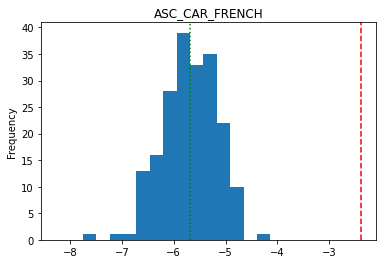

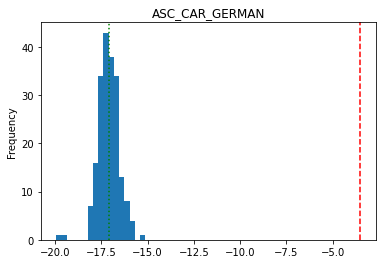

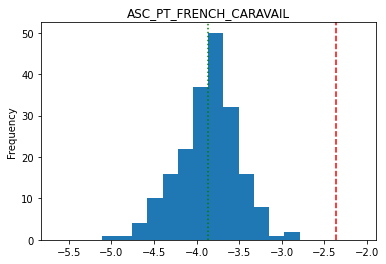

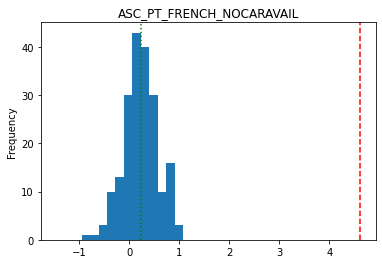

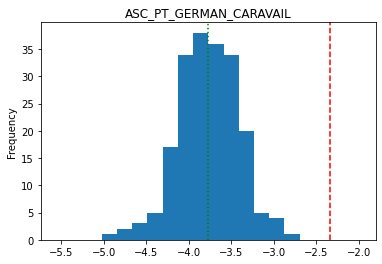

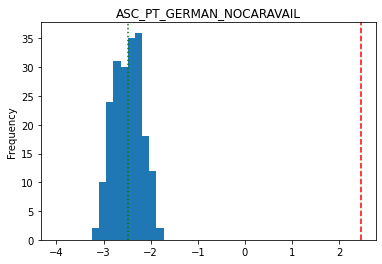

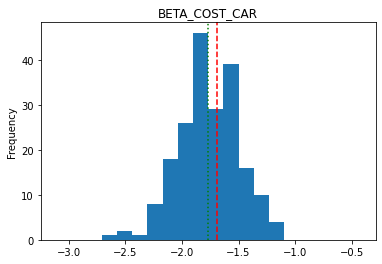

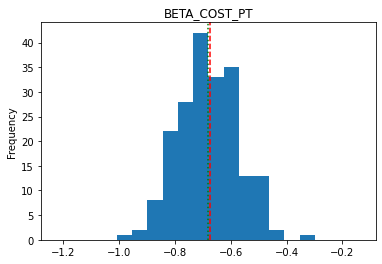

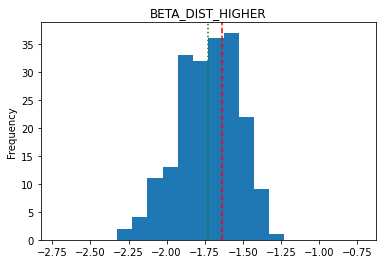

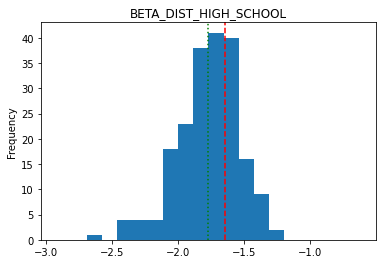

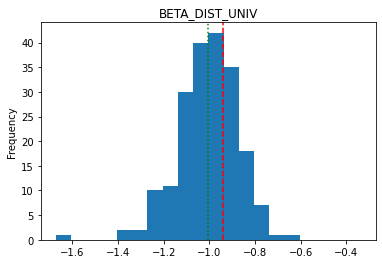

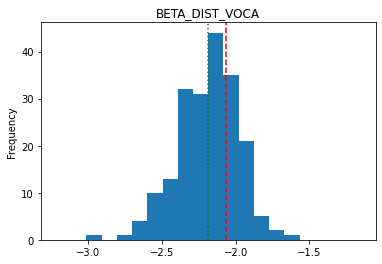

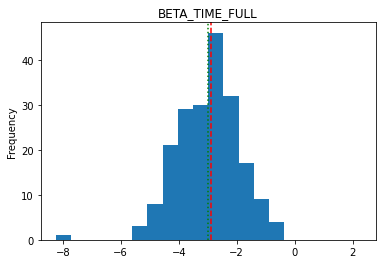

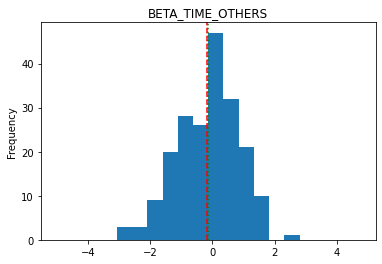

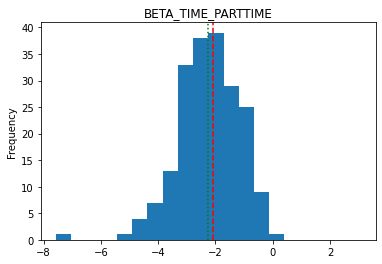

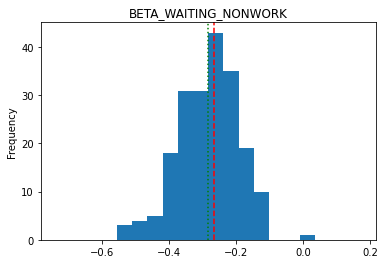

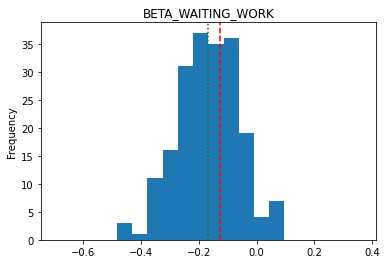

In [31]:
report(resultsESS2, comparisonsESS2)